In [50]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

from wordcloud import WordCloud
from tensorflow.keras import layers,models,losses, Sequential, optimizers, metrics


In [51]:
tweets_data = pd.read_csv('Tweets.csv')
tweets_data.sample(10)

,textID,text,selected_text,sentiment
5410,75cd2ad7ce,absolutely nothin,absolutely nothin,neutral
11579,1a35c1eb9f,sorry to disappoint.,sorry to disappoint.,negative
9595,46c3c562ce,My long lost friend!,lost,negative
1756,62c9c4f81f,Getting very frustrated by people who don`t kn...,frustrated,negative
5795,1548476690,Traffic jam outside of chicago. I feel very 'o...,I feel very 'office space' right now.,positive
26082,e0f834083a,Algebra test in three hours!,Algebra test in three hours!,neutral
17830,0f586bad99,9 more week! July 8th. Flolloping just perfec...,perfectly,positive
10544,372aef3c66,"I`ve done nothing today apart from moan,whinge...","moan,whinge,moan",negative
12357,d6528f1f21,"Birthday **** is a great song, man. Somethin...","a great song,",positive
26799,939823c9f7,Just thinking that it will all pay off in the ...,Just thinking that it will all pay off in the ...,neutral


In [52]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [53]:
tweets_data= tweets_data.dropna()
tweets_data.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [54]:
tweets_data.duplicated().sum()

0

In [55]:
# tweets_data = tweets_data.drop(columns=["selected_text","textID"])
tweets_data.sample(10)

,textID,text,selected_text,sentiment
14848,ded5c078aa,i hate getting put on steroids. my face,i hate getting put on steroids.,negative
24,0c8cc71c46,SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cA...,SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cA...,neutral
16270,c8d42cbef7,Nobody ever ` s makes me sad,Nobody ever ` s makes me sad,neutral
26877,6b1bf8be78,i have a fever,i have a fever,negative
13241,efaac7b587,I am so bored. My homework is done for my mas...,I am so bored.,negative
23710,cb3268ba79,worried about Mr. Socks tonight.,worried,negative
15594,83229c2a8a,_Foster Just so i can see how they look with t...,_Foster Just so i can see how they look with t...,neutral
22353,19c8d8ff2a,"Did we hear our name ? Thanks Ankit, get them...",Thanks,positive
6024,3771d481c0,I gave a homeless lady named Ruby an Ice Cream...,I gave a homeless lady named Ruby an Ice Cream...,positive
8968,fdac594a05,"Thanks for asking, Sarah I am glad tomorrow ...",m glad,positive


<AxesSubplot: xlabel='sentiment', ylabel='count'>

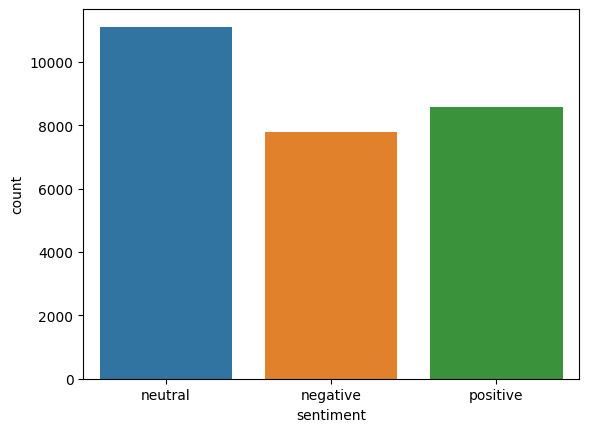

In [56]:
import seaborn as sns
sns.countplot(data=tweets_data,x="sentiment")

In [57]:
tweets_data["word_count"] = tweets_data["text"].apply(lambda x: len(str(x).split()))
tweets_data[["text", "word_count"]].sample(10)


,text,word_count
8283,hahah im way too lazy to check my phone ooo ...,16
11832,Just got to school. Goin to Cinncinatti Wednes...,8
21523,Morning. Off to school... Ickkk!,5
19264,hahahaha awww uduhn lun me no mor???,7
7056,"Ordered mine, thank you!!",4
26037,looking forward to Ben`s baseball game tonight,7
2892,"yeah, getting shows can be an interesting pro...",21
9505,it will be 45+ in June/July,6
8646,exactly like that ...in glasgow now ...it`s a...,10
6894,the dog dug a hole in the backyard well iwas s...,14


In [58]:
tweets_data.groupby("sentiment")["word_count"].mean()

sentiment
negative    13.473204
neutral     12.343888
positive    13.109881
Name: word_count, dtype: float64

<AxesSubplot: xlabel='word_count', ylabel='Count'>

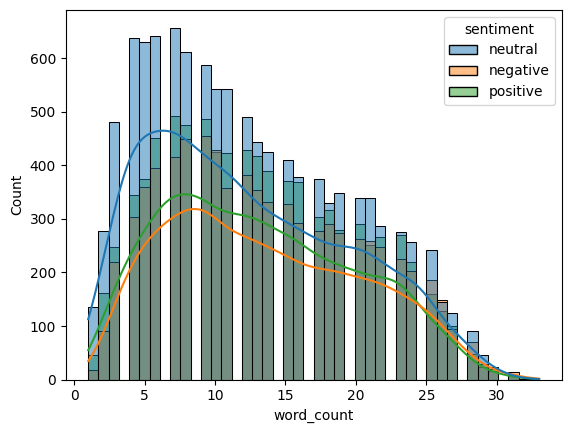

In [59]:
sns.histplot(data = tweets_data, x="word_count",hue="sentiment",kde= True)

In [60]:
from nltk.corpus import stopwords

nltk.download("stopwords")

stop_words = stopwords.words("english")

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
import string
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)

    stripped_urls = tf.strings.regex_replace(lowercase,r"https?://\S+|www\.S+","")
    

    stripped_symbol = tf.strings.regex_replace(stripped_urls,"\S+@\S+\s?","")

    stripped_brackets =tf.strings.regex_replace(stripped_symbol,"<.*?>+","")

    stripped_brackets =tf.strings.regex_replace(stripped_brackets,"\[|\]","")
    stripped_digits =tf.strings.regex_replace(stripped_brackets,"\w*\d\w*","")

    stripped_stopwords = tf.strings.regex_replace(stripped_digits,r"\b(?:{})\b".format("|".join(stop_words)),"")

    striped_whitespace_chars = tf.strings.regex_replace(stripped_stopwords,"\s+"," ")

    return tf.strings.regex_replace(striped_whitespace_chars,r"[^a-zA-Z\s]+","")

In [62]:
tweets_data["text"][11827]
custom_standardization(tweets_data["text"][11827]).numpy()

b' degree tear happy moment '

In [63]:
tweets_data["cleaned_text"]=tweets_data["text"].apply(custom_standardization)
tweets_data

,textID,text,selected_text,sentiment,word_count,cleaned_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,"tf.Tensor(b' responded going', shape=(), dtyp..."
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10,"tf.Tensor(b' sooo sad miss san diego', shape=(..."
2,088c60f138,my boss is bullying me...,bullying me,negative,5,"tf.Tensor(b' boss bullying ', shape=(), dtype=..."
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5,"tf.Tensor(b' interview leave alone', shape=(),..."
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14,tf.Tensor(b' sons put releases already bough...
...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,16,tf.Tensor(b' wish could come see u denver husb...
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,23,tf.Tensor(b' wondered rake client made clear...
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,22,tf.Tensor(b' yay good enjoy break probably n...
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,6,"tf.Tensor(b' worth ', shape=(), dtype=string)"


In [64]:
def tensor_to_string(tensor):
    return tensor.numpy().decode("utf-8")
tweets_data["cleaned_text"]= tweets_data["cleaned_text"].apply(tensor_to_string)
tweets_data


,textID,text,selected_text,sentiment,word_count,cleaned_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10,sooo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,5,boss bullying
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5,interview leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14,sons put releases already bought
...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,16,wish could come see u denver husband lost job...
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,23,wondered rake client made clear net force...
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,22,yay good enjoy break probably need hectic w...
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,6,worth


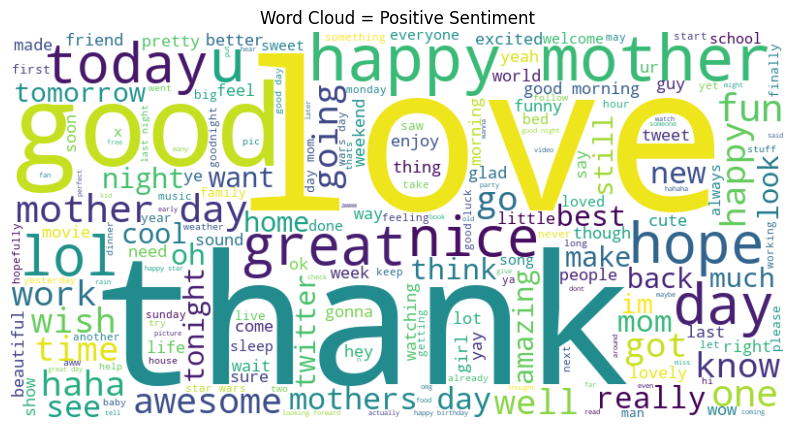

In [65]:
positive_tweets = tweets_data[tweets_data["sentiment"]=="positive"]["cleaned_text"]

positive_text=" ".join(positive_tweets)

wordcloud = WordCloud(width = 800,height = 400,background_color="white").generate(positive_text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud = Positive Sentiment")
plt.show()

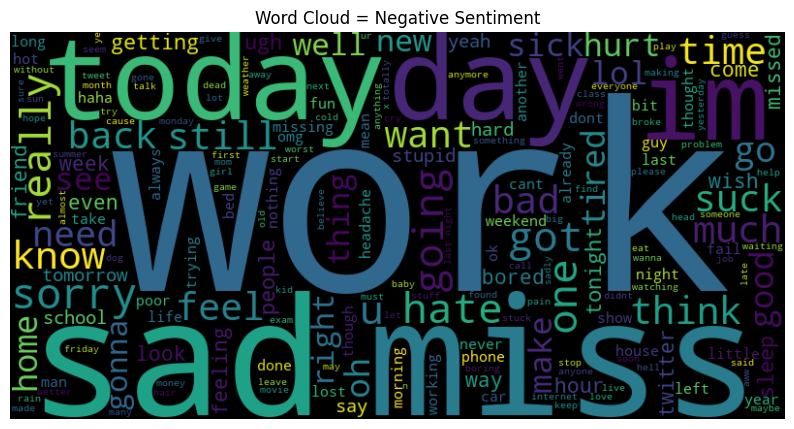

In [66]:
negative_tweets = tweets_data[tweets_data["sentiment"]=="negative"]["cleaned_text"]

negative_text=" ".join(negative_tweets)

wordcloud = WordCloud(width = 800,height = 400,background_color="black").generate(negative_text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud = Negative Sentiment")
plt.show()

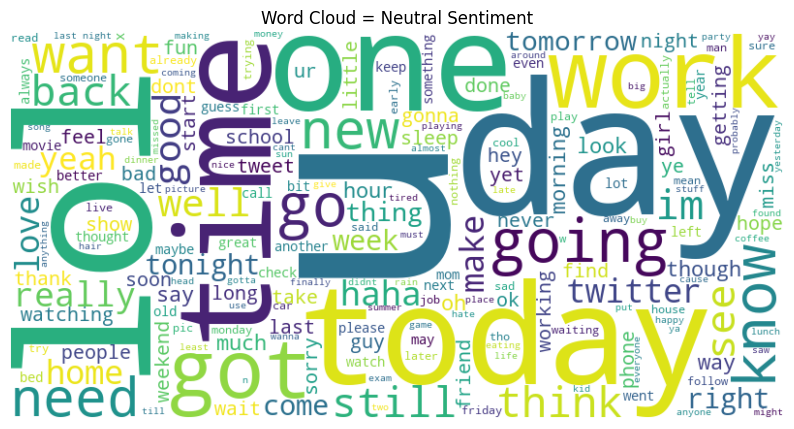

In [67]:
neutral_tweets = tweets_data[tweets_data["sentiment"]=="neutral"]["cleaned_text"]

neutral_text=" ".join(neutral_tweets)

wordcloud = WordCloud(width = 800,height = 400,background_color="white").generate(neutral_text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud = Neutral Sentiment")
plt.show()

In [68]:
tweets_data["sentiment"]= tweets_data["sentiment"].replace({
    "negative" :0,
    "neutral":1,
    "positive":2
})
tweets_data.sample(10)

,textID,text,selected_text,sentiment,word_count,cleaned_text
216,234093bef1,which means you`re just going to have to come...,which means you`re just going to have to come ...,1,18,means going come back vancouver way hahah
6667,7205bd413f,haha.. good for you,haha.. good for you,2,4,haha good
21959,0cdfa00a5a,not goin tto tafe,not goin tto tafe,1,4,goin tto tafe
4780,81cc41b606,Aw what about me,Aw what about me,1,4,aw
1097,4367f31dec,uploading pictures on myspace,uploading pictures on myspace,1,4,uploading pictures myspace
25706,fa0365ff09,**** it...Margie said she couldn`t share the i...,**** it...,0,24,margie said share info killed evil eddy want...
8727,97b1409906,http://bit.ly/NYhMZ Dionusia made me do it,http://bit.ly/NYhMZ Dionusia made me do it,1,6,dionusia made
15807,241a132a38,Am trying to get through the pilot of the firs...,Am trying to get through the pilot of the firs...,1,20,trying get pilot first season friday night li...
21111,a9bd9a71f1,Missed the hello kitty not enough time oh well,Missed the hello kitty,0,9,missed hello kitty enough time oh well
11395,bb21279826,Going to bed Goodnight xox,Going to bed Goodnight xox,1,5,going bed goodnight xox


In [69]:
from sklearn.model_selection import train_test_split
x_train,x_test = train_test_split(tweets_data,test_size=0.2,stratify=tweets_data["sentiment"],random_state=123)
x_train,x_val = train_test_split(x_train,test_size=0.1,stratify=x_train["sentiment"],random_state=123)
x_train.shape,x_val.shape, x_test.shape

((19785, 6), (2199, 6), (5496, 6))

In [70]:
x_test["sentiment"].value_counts()

1    2223
2    1717
0    1556
Name: sentiment, dtype: int64

In [71]:
raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train["text"].values,x_train["sentiment"].values)).shuffle(1024).batch(batch_size=128)
raw_val_ds = tf.data.Dataset.from_tensor_slices(
    (x_val["text"].values,x_val["sentiment"].values)).batch(batch_size=128)
raw_test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test["text"].values,x_test["sentiment"].values)).batch(batch_size=128)


len(raw_train_ds),len(raw_test_ds),len(raw_val_ds)

(155, 43, 18)

In [72]:
vocab_size = 30

count_vectorizer = layers.TextVectorization(
    standardize = "lower_and_strip_punctuation",
    max_tokens = vocab_size,
    output_mode="count"
)

In [73]:
text=["Malcolm is an amazing painter.Malcom also loves watching cricket","Dean cooks well",
      "Malcolm is a decent footballer too",
      "Chris is a teacher, he is quite experienced in teaching"]
count_vectorizer.adapt(text)
count_vectorizer.get_vocabulary()

['[UNK]',
 'is',
 'malcolm',
 'a',
 'well',
 'watching',
 'too',
 'teaching',
 'teacher',
 'quite',
 'paintermalcom',
 'loves',
 'in',
 'he',
 'footballer',
 'experienced',
 'decent',
 'dean',
 'cricket',
 'cooks',
 'chris',
 'an',
 'amazing',
 'also']

In [74]:
count_vectorizer(text)

<tf.Tensor: shape=(4, 24), dtype=float32, numpy=
array([[0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)>

In [75]:
vocab_size = 10000

count_vectorizer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode="count",
    ngrams=(1,2)
)

In [76]:
train_text = raw_test_ds.map(lambda x,y:x)
count_vectorizer.adapt(train_text)

In [77]:
def vectorize_text(text,label):
    text = tf.expand_dims(text,-1)

    return count_vectorizer(text),label

In [78]:
import sys
np.set_printoptions(threshold=sys.maxsize)

class_names = ["negative","neutral","positive"]
text_batch, label_batch = next(iter(raw_train_ds))
first_tweet,first_label = text_batch[0],label_batch[0]

print("Tweet", first_tweet)
print("Sentiment", class_names[first_label])
print("Vectorized review", vectorize_text(first_tweet,first_label))

Tweet tf.Tensor(b'forgot the montel quote  and it was a good one..', shape=(), dtype=string)
Sentiment neutral
Vectorized review (<tf.Tensor: shape=(1, 10000), dtype=float32, numpy=
array([[4., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.

In [79]:

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [80]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [88]:
from keras.models import Sequential
from keras.layers import Dense

dnn_model = Sequential([
    Dense(64, input_shape=(64,), activation='relu'),  # Adjust input shape here
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [89]:
dnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

input_shape = (None,10000)

dnn_model.build(input_shape)
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,273
Trainable params: 6,273
Non-trainable params: 0
_________________________________________________________________


In [93]:
from keras.models import Sequential
from keras.layers import Dense

# Assuming your model is sequential
dnn_model = Sequential([
    Dense(64, input_shape=(10000,), activation='relu'),  # Adjust input shape here
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile your model
dnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Now you can use fit method with your data
history = dnn_model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds
)


Epoch 1/50
155/155 [==============================] - 5s 25ms/step - loss: -1.5651 - accuracy: 0.4041 - val_loss: -7.0886 - val_accuracy: 0.4120
Epoch 2/50
155/155 [==============================] - 4s 25ms/step - loss: -32.1525 - accuracy: 0.4202 - val_loss: -74.7810 - val_accuracy: 0.4266
Epoch 3/50
155/155 [==============================] - 4s 25ms/step - loss: -170.8916 - accuracy: 0.4308 - val_loss: -286.7511 - val_accuracy: 0.4316
Epoch 4/50
155/155 [==============================] - 4s 24ms/step - loss: -501.9586 - accuracy: 0.4334 - val_loss: -711.5113 - val_accuracy: 0.4325
Epoch 5/50
155/155 [==============================] - 4s 24ms/step - loss: -1095.5592 - accuracy: 0.4336 - val_loss: -1407.8335 - val_accuracy: 0.4325
Epoch 6/50
155/155 [==============================] - 4s 25ms/step - loss: -2007.9541 - accuracy: 0.4342 - val_loss: -2420.0249 - val_accuracy: 0.4320
Epoch 7/50
155/155 [==============================] - 4s 25ms/step - loss: -3284.2378 - accuracy: 0.4339 - v